This file is written to compare the epd fasta file that contain sequences of promoters, filtered based on capable to find corresponding Ensembl ID. Then this is compared with the RNA-seq file that contain RNA-seq data for a single sample, where the RNA-seq matrix is filtered based on corresponding ENsembl ID from epd fasta file.

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/master_thesis/inputs

/content/drive/MyDrive/master_thesis/inputs


In [4]:
try:
    import google.colab
    # Running on Google Colab, so install Biopython first
    !pip install biopython
except ImportError:
    pass

     |████████████████████████████████| 2.3 MB 5.1 MB/s 


In [5]:
try:
    import google.colab
    # Running on Google Colab, so install Biopython first
    !pip install mygene
except ImportError:
    pass

In [6]:
from Bio import SeqIO
import csv
import mygene
mg = mygene.MyGeneInfo()
import pandas as pd
from google.colab import data_table
import numpy as np
import os

In [7]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

pd.set_option('display.max_columns', None)

In [8]:
def epdparser(fasta_file):
  """convert gene symbol/ID to Ensembl gene ID

  Args:
  fasta_file = txt file containing fasta records from epd promoter database
  output:
  epd_pd = dataframe of 2 columns Promoter_ID, Sequence
  """
  Promoter_seq_pairs = []
  with open(fasta_file) as handle:
    for value in SeqIO.FastaIO.SimpleFastaParser(handle):
      Promoter_ID = value[0].split()[1][:-2]
      seq = value[1]
      Promoter_seq_pairs.append([Promoter_ID, seq])
  epd_df = pd.DataFrame(Promoter_seq_pairs, columns = ("Promoter_ID",\
                                                   "Sequence"))
  return epd_df

In [ ]:
def genesymboltoensemblid(epd_df):
  """convert gene symbol/ID to Ensembl gene ID

  input:
  epd_df = dataframe of two columns, Promoter_ID and Sequence
  output:
  matching_df = dataframe of three columns gene_id, Ensembl_ID, 
               and Sequence. Contain respective gene name, Ensembl_ID, 
              sequence of a promoter.
  """
  match_list = []
  genesymbol_list = epd_df["Promoter_ID"].tolist()
  seq_list = epd_df["Sequence"].tolist()
  output = mg.querymany(genesymbol_list, scopes='symbol'\
                        , fields='ensembl.gene', species='human', returnall=False)
  for record in output:
    gene_sym, ensembl_ids= None, None
    #when query does not have corresponding ensembl id
    if 'notfound' in record.keys():
      if record["notfound"]:
        pass
    else:
      gene_sym = record["query"]
      seq = seq_list[genesymbol_list.index(gene_sym)]
      #ensembl id returns sometimes as a list of dicts when multiple ensembl
      #ids were matched to
      if "ensembl" in record.keys():
        ensembl_ids = record["ensembl"]
        #select first ensembl id from list of dicts
        if type(ensembl_ids) is list:
          ensembl_id = ensembl_ids[0]["gene"]
        else:
          ensembl_id = ensembl_ids["gene"]
      match_list.append([gene_sym, ensembl_id, seq])
    match_df = pd.DataFrame(match_list, columns = ("gene_id",\
                                                   "Ensembl_ID", "Sequence"))
  return match_df

In [ ]:
def remove_version(Ensembl_ID):
  """remove version number from gene_id

  Args:
  gene_id = string, contain gene_id and version after .
  output:
  epd_pd = string, contain gene_id
  """
  if "." in Ensembl_ID:
    Ensembl_ID = Ensembl_ID.split(".", 1)[0]
  return Ensembl_ID

def RNAseqparser(RNAseqfile):
  """Parse RNAseq matrix to extract relevant columns

  Args:
  RNAseqfile = csv file containing RNA-seq data
  output:
  rd = dataframe of three columns, gene_id, TPM, FPKM
  """
  rd = pd.read_csv(open(RNAseqfile), delimiter="\t", quotechar='"', \
                    usecols = ["gene_id", "TPM", "FPKM"])
  #remove different versions from gene_id column
  rd["gene_id"] = rd["gene_id"].apply(remove_version)
  return rd

In [ ]:
def RNAseq_matches(RNA_seq_matrix, matching_df):
  """compare if rows in RNA_seq_matrix has gene_id that is corrispond to 
      matching_df's Ensembl_ID, these rows are sublisted and
      duplicates are removed

  Args:
  RNA_seq_matrix = dataframe of three columns, gene_id, TPM, FPKM
  matching_df = dataframe of three columns gene_id, Ensembl_ID, 
               and Sequence. Contain respective gene name, Ensembl_ID, 
              , sequence of a promoter.
  output:
  rd = dataframe of three col, Ensembl_ID, TPM, FPKM
  """
  matching_list = matching_df["Ensembl_ID"].tolist()
  sub_matrix = RNA_seq_matrix[RNA_seq_matrix["gene_id"].isin(matching_list)]
  return sub_matrix

In [ ]:
def joinsequenceapply(match_df, parsed_matrix):
  """join the match_df and parsed_matrix based on the ensembl ID of each
      record, to link the RNA-Seq data to the Sequence

  Args:
  parsed_matrix = dataframe of three columns, gene_id, TPM, FPKM.
  matching_df = dataframe of three columns gene_id, Ensembl_ID, 
               and Sequence. Contain respective gene name, Ensembl_ID, 
              , sequence of a promoter.
  output:
  joined_matrix = dataframe of 5 col, Ensembl_ID, TPM, FPKM, gene_id and Sequence, each row
        contain information of the 5 categories of a single promoter and its
        respective gene
  """
  gene_ids = parsed_matrix["gene_id"].tolist()
  #filter match_df with those only contain ensembl_ID in parsed_matrix
  match_df_Ensembl_ID = match_df[match_df["Ensembl_ID"].isin(gene_ids)]
  renamed_parsed_matrix = parsed_matrix.rename({"gene_id": "Ensembl_ID"}, axis=1)
  joined_matrix = pd.merge(renamed_parsed_matrix, match_df_Ensembl_ID, on=["Ensembl_ID"])
  return joined_matrix

In [ ]:
def wrapperparser(epd_fasta_file, RNA_seq_file):
    """
    Wrapper that combine RNA-seq file and epd promoter files

    Arg:
    epd_fasta_file = fasta file generated epd promoter database
    RNA_seq_file = tsv file that contain the RNA_seq data of a sample

    Output:
    joined_matrix = dataframe of 5 col, Ensembl_ID, TPM, FPKM, gene_id and Sequence, each row
          contain information of the 5 categories of a single promoter and its
          respective gene. 
    """
    name = epd_fasta_file[:-4] + "_" + RNA_seq_file[:-4]
    if os.path.isdir(name):
        pass
    else:
        os.mkdir(name)
    tsv_name = os.path.join(name, name + ".csv")
    Promoter_seq_pd = epdparser(epd_fasta_file)
    match_df = genesymboltoensemblid(Promoter_seq_pd)
    RNA_seq_matrix = RNAseqparser(RNA_seq_file)
    parsed_matrix = RNAseq_matches(RNA_seq_matrix, match_df)
    joined_matrix = joinsequenceapply(match_df, parsed_matrix)
    joined_matrix['TPM'] = joined_matrix['TPM'] + 1
    joined_matrix['logTPM'] = np.log2(joined_matrix['TPM'])
    joined_matrix['FPKM'] = joined_matrix['FPKM'] + 1
    joined_matrix['logFPKM'] = np.log2(joined_matrix['FPKM'])
    if os.path.isfile(tsv_name) == False:
        joined_matrix.to_csv(tsv_name)
    return joined_matrix

In [ ]:
ls

ENCFF292FVY.tsv  ENCFF694PZC.tsv  ENCFF910TAZ.tsv  hg38_msxTm.txt


In [ ]:
final_matrix_1 = wrapperparser("hg38_msxTm.txt", "ENCFF910TAZ.tsv")
final_matrix_2 = wrapperparser("hg38_msxTm.txt", "ENCFF292FVY.tsv")

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-2067...done.
Finished.
2 input query terms found dup hits:
	[('GLRA4', 2), ('SLC26A10', 2)]
78 input query terms found no hit:
	['CTB-25J19', 'HIST1H2BN', 'MARCH2', 'C10orf10', 'HIST2H4B', 'HIST2H2BF', 'FAM71C', 'NOV', 'CYR61', 
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-2067...done.
Finished.
2 input query terms found dup hits:
	[('GLRA4', 2), ('SLC26A10', 2)]
78 input query terms found no hit:
	['CTB-25J19', 'HIST1H2BN', 'MARCH2', 'C10orf10', 'HIST2H4B', 'HIST2H2BF', 'FAM71C', 'NOV', 'CYR61', 
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


normalization by distribution of data: add pseudocount 1 to TPM and FPKM columns, and perform log2 transformation
https://www-ncbi-nlm-nih-gov.ezproxy.library.wur.nl/pmc/articles/PMC6171491/

In [ ]:
import os

os.mkdir("example")

In [ ]:
ls

ENCFF910TAZ.tsv   hg38_msxTm_ENCFF910TAZ/     hg38_msxTm.txt
final_matrix.csv  hg38_msxTm_ENCFF910TAZ.csv


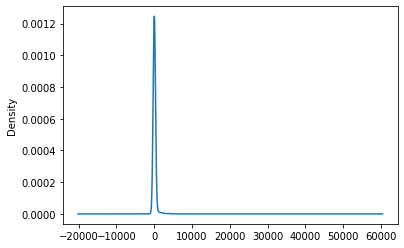

In [ ]:
final_matrix["TPM"].plot.kde()

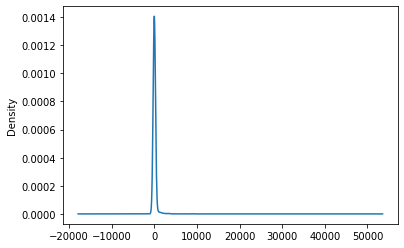

In [ ]:
final_matrix["FPKM"].plot.kde()

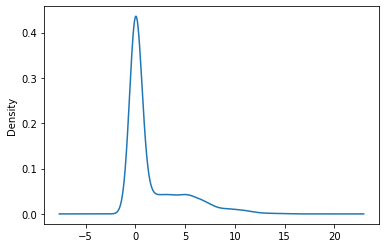

In [ ]:
final_matrix["logTPM"].plot.kde()

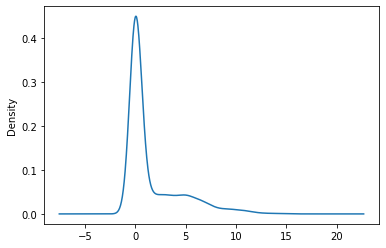

In [ ]:
final_matrix["logFPKM"].plot.kde()

In [ ]:
final_matrix.to_csv('hg38_msxTm_ENCFF910TAZ.csv') 

In [ ]:
ls

ENCFF910TAZ.tsv  final_matrix.csv  hg38_msxTm.txt


In [10]:
cd /content/drive/My Drive/master_thesis/inputs/find_motifs/

/content/drive/My Drive/master_thesis/inputs/find_motifs


In [11]:
ls

attention_scores.npz  attention_scores.npz.npy  negatives.fa.txt  sequences.npy


In [12]:
negatives = epdparser("negatives.fa.txt")

In [13]:
print(negatives.shape)

(26533, 2)


In [15]:
negatives_np = negatives["Sequence"].to_numpy()

In [18]:
np.save("negative_seqs", negatives_np)